# *PART A*

**QUESTION 1**

Türkiye için veri deseni tarih, yeni vaka sayısı ve her satırın yanına günlük vaka sayılarının önceki hafta aynı güne göre değişimini getirecek sorguyu hazırlayınız (Örneğin önceki hafta 2021-05-01’de 900 2021-05-08’de 920 vaka var ise bu kolonun değeri 2021-05-08 için 20 olacaktır).

**Query:**
~~~ sql
SELECT
    t1.date,
    t1.new_confirmed,
    -- t2.new_confirmed AS previous_week_cases,
    t1.new_confirmed - t2.new_confirmed AS weekly_change
FROM `bigquery-public-data.covid19_open_data.covid19_open_data` t1
LEFT JOIN `bigquery-public-data.covid19_open_data.covid19_open_data` t2
ON t1.country_name = t2.country_name
AND DATE_SUB(t1.date, INTERVAL 7 DAY) = t2.date
WHERE t1.country_name = 'Turkey'
ORDER BY t1.date DESC;
~~~

**Query Result:**

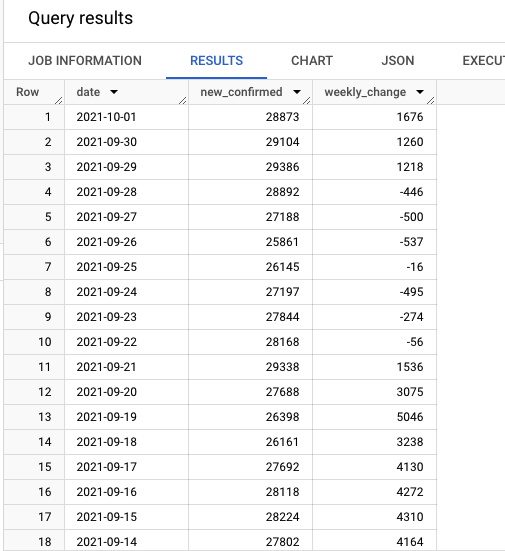


**QUESTION 2**

2021 boyunca Türkiye’nin her ay sonunda aşılanmış nüfus oranının bütün ülkeler arasındaki sırası ve yüzdelik dilimini veren sorguyu hazırlayınız. Veri deseni ay (nümerik veya ay ismi), sıra, yüzdelik dilim seklinde olabilir.

**Query:**

~~~ sql
WITH monthly_data AS (
    /* Select distinct countries with vaccination rates for each month */
    SELECT
        country_name,
        date,
        population,
        cumulative_persons_fully_vaccinated,
        SAFE_DIVIDE(cumulative_persons_fully_vaccinated, population) AS vaccination_rate,
        EXTRACT(MONTH FROM date) AS month
    FROM bigquery-public-data.covid19_open_data.covid19_open_data
    WHERE EXTRACT(YEAR FROM date) = 2021
    AND cumulative_persons_fully_vaccinated IS NOT NULL
    AND population IS NOT NULL
    AND aggregation_level = 0
)
, last_day_data AS (
    /* Get the last available date for each country in each month */
    SELECT
        country_name,
        month,
        MAX(date) AS last_day
    FROM monthly_data
    GROUP BY country_name, month
)
, ranked_data AS (
    /* Rank countries within each month based on vaccination rate */
    SELECT
        m.month,
        m.country_name,
        m.vaccination_rate,
        RANK() OVER (PARTITION BY m.month ORDER BY m.vaccination_rate DESC) AS rank,
        ROUND(
            100 * (RANK() OVER (PARTITION BY m.month ORDER BY m.vaccination_rate DESC))
            / COUNT(*) OVER (PARTITION BY m.month),
            2
        ) AS percentile_position
    FROM monthly_data m
    JOIN last_day_data l
    ON m.country_name = l.country_name
    AND m.date = l.last_day
)
SELECT
    month,
    rank,
    percentile_position,
FROM ranked_data
WHERE country_name = 'Turkey'
ORDER BY month;  
~~~

**Query Result:**

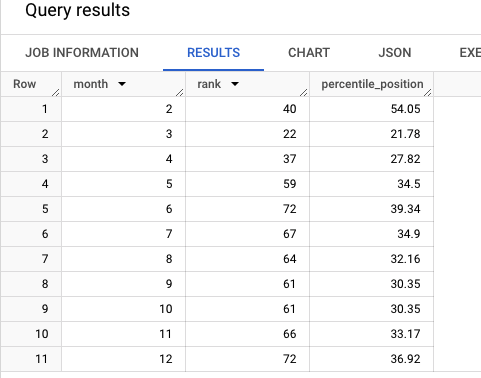

# PART B

# **SQL Query: Extracting the COVID-19 Dataset**  

To uncover trends and anomalies in COVID-19 data, we extracted key metrics using the following SQL query:  
~~~ sql
SELECT
    date,
    country_name,
    new_confirmed AS daily_cases,
    new_deceased AS daily_deaths,
    SAFE_DIVIDE(new_deceased, new_confirmed) * 100 AS CFR, -- Case Fatality Rate (CFR)
    new_tested AS daily_tests,
    SAFE_DIVIDE(new_confirmed, SAFE_CAST(new_tested AS FLOAT64)) * 100 AS positivity_rate
FROM `bigquery-public-data.covid19_open_data.covid19_open_data`
WHERE country_name IN ('Germany', 'Finland', 'Turkey', 'Greece')
AND aggregation_level = 0
AND EXTRACT(YEAR FROM date) = 2020;
~~~

# **Loading and Exploring Turkey's COVID-19 Data**
This script loads the **COVID-19 dataset for Turkey**,

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "data.csv"
df = pd.read_csv(file_path)

df['date'] = pd.to_datetime(df['date'])
df = df[df['country_name'] == 'Turkey'].copy()
df = df.dropna(subset=['daily_cases', 'daily_tests', 'CFR', 'positivity_rate'])
df = df.sort_values(by='date')

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 280 entries, 673 to 628
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             280 non-null    datetime64[ns]
 1   country_name     280 non-null    object        
 2   daily_cases      280 non-null    float64       
 3   daily_deaths     280 non-null    float64       
 4   CFR              280 non-null    float64       
 5   daily_tests      280 non-null    float64       
 6   positivity_rate  280 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 17.5+ KB
None
           date country_name  daily_cases  daily_deaths       CFR  \
673  2020-03-27       Turkey       2069.0          17.0  0.821653   
1407 2020-03-28       Turkey       1704.0          16.0  0.938967   
266  2020-03-29       Turkey       1815.0          23.0  1.267218   
1447 2020-03-30       Turkey       1610.0          37.0  2.298137   


# **Two Peaks, Two Stories: Understanding Turkey’s 2020 COVID-19 Trends**


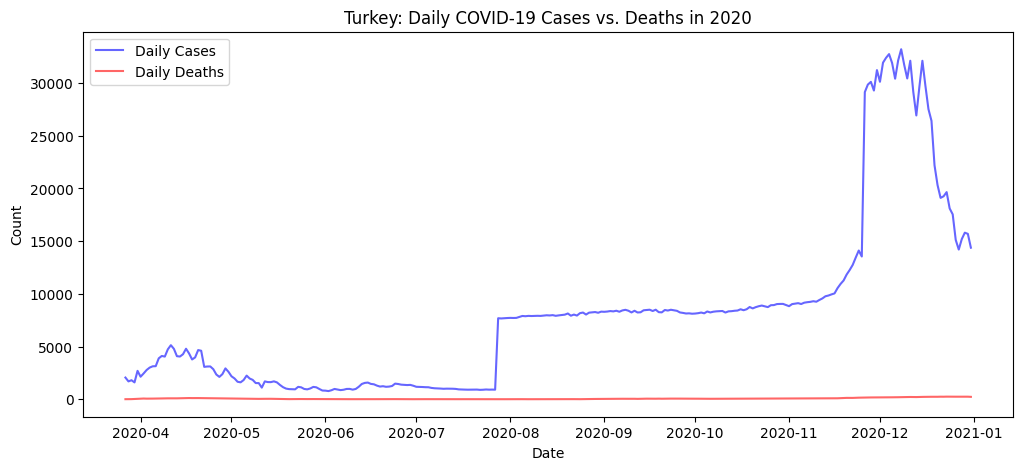

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['daily_cases'], label="Daily Cases", color='blue', alpha=0.6)
plt.plot(df['date'], df['daily_deaths'], label="Daily Deaths", color='red', alpha=0.6)
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Turkey: Daily COVID-19 Cases vs. Deaths in 2020")
plt.legend()
plt.show()

The graph highlights **two major peaks** in Turkey’s reported daily COVID-19 cases during 2020:

## **1. First Peak (Late July 2020)**  
- A **noticeable increase in reported cases** occurs around late July.  
- Possible explanations include:  
  - **Changes in case reporting criteria:** Before this period, Turkey may have been reporting only **hospitalized** COVID-19 patients rather than all positive cases. If the reporting system was updated to include **all confirmed cases**, this could explain the sudden rise.  
  - **Expanded testing:** An increase in the number of tests conducted could have revealed more cases.  
  - **Eid al-Adha (Kurban Bayramı) impact:** This religious holiday at the end of July may have led to increased social gatherings and travel, accelerating virus spread.  
  - **Seasonal effects & relaxation of restrictions:** Many countries saw increased mobility during the summer, potentially leading to rising cases.  

- **To determine if this was Turkey-specific**, it would be useful to compare trends with other countries that had similar events or seasonal travel patterns.  

## **2. Second Peak (Late November - Early December 2020)**  
- A **much larger peak** appears towards **late November and early December**.  
- This aligns with the **global second wave**, where many countries experienced a surge due to:  
  - **Colder weather & indoor activities** increasing transmission risk.  
  - **Pandemic fatigue** leading to reduced adherence to restrictions.  
  - **Economic pressures & reopening efforts** before winter.  
  - **Better testing infrastructure & case reporting updates.**  

- If **Turkey had only been reporting hospitalized cases before July**, but then transitioned to reporting **all positive cases**, then the true size of the **first wave may have been hidden**.  
- The second peak in November-December might reflect **actual transmission trends rather than just a data adjustment**.  

## **Next Steps for Further Analysis**  
- **Compare with Germany, Finland, and Greece** to see if they had similar patterns in July and November.  
  - **Germany**: Chosen as a **trustworthy reference country within the EU**, known for its transparent and systematic approach to pandemic management. If Germany experienced similar peaks, it would indicate a more global trend.  
  - **Greece**: Selected due to **its geographical proximity to Turkey**, allowing us to assess whether regional factors (e.g., climate, tourism, or mobility between neighboring countries) played a role.  
  - **Finland**: Included **for randomness** to see if a country with a different climate, population density, and government approach had comparable trends, helping to differentiate between **global vs. Turkey-specific effects**.  
- **Analyze Turkey’s positivity rate over time** to determine if underreporting may have played a role before the first peak.  



# **Turkey’s CFR Mystery: A Shift in Reporting or a Shift in Reality?**  



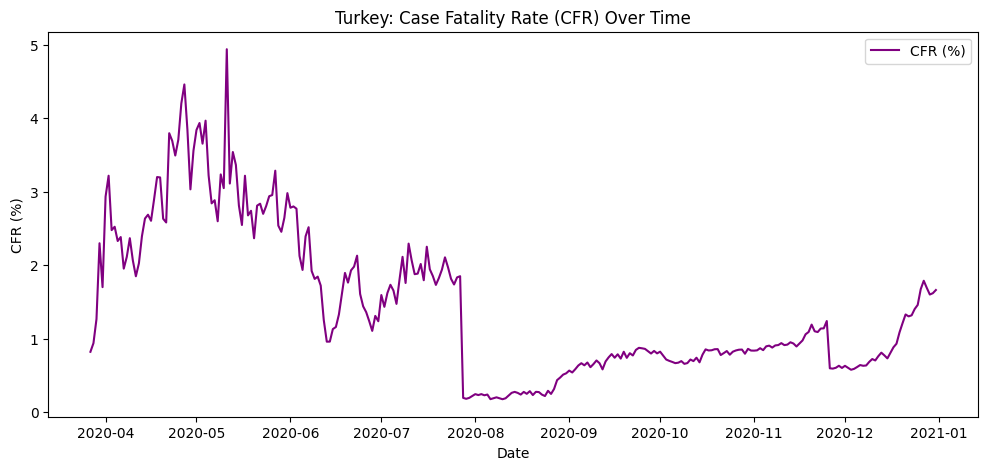

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['CFR'], color='purple', label="CFR (%)")
plt.xlabel("Date")
plt.ylabel("CFR (%)")
plt.title("Turkey: Case Fatality Rate (CFR) Over Time")
plt.legend()
plt.show()

## **What is CFR (Case Fatality Rate)?**  
The **Case Fatality Rate (CFR)** measures the percentage of **confirmed COVID-19 cases that result in death**. It is calculated as:  

In SQL, this is implemented as:  

```sql
SAFE_DIVIDE(new_deceased, new_confirmed) * 100 AS CFR
```

## Key Observations on Turkey's CFR in 2020

### **High CFR before July 2020 (2% - 5%)**  
Before July, the case fatality rate was unusually high, suggesting that **only severe cases—likely those hospitalized—were being reported.**  
Mild and asymptomatic cases may have been **underreported or not included in official counts**.

### **Sudden Drop in July 2020 (~0%)**  
A dramatic shift occurs in **July 2020**, where CFR nearly drops to **zero**.  
This is a strong indicator that **Turkey changed its case reporting methodology**, likely transitioning from reporting **only hospitalized cases** to **all positive cases**.

### **Gradual Rise After August 2020**  
Following the reporting shift, CFR begins to **creep upward again**.  
This could signal an **increased strain on the healthcare system** or reflect the **global second wave** that surged in late 2020.

---

## **Why This Matters**
- A sudden **CFR drop doesn’t necessarily mean the virus became less deadly**, it often means **testing expanded** and milder cases were included.  
- To determine whether this was a **Turkey-specific trend or part of a global pattern**, comparing with **Germany, Greece, and Finland** is crucial.  
- **Germany** provides a reliable **EU benchmark**, **Greece** offers **regional comparison**, and **Finland** gives a **random control case** for contrast.

Would further analysis across multiple countries confirm this trend? Time to find out.




# **Beyond Turkey: Did Greece, Germany, and Finland Follow the Same Trend?** 🇹🇷 🇬🇷 🇩🇪 🇫🇮  

**Was This a Global Shift or a Turkey-Specific Anomaly?**  


In [ ]:
import pandas as pd

file_path = "data.csv"
df = pd.read_csv(file_path)

df['date'] = pd.to_datetime(df['date'])

print(df.info())
print(df.head())

print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1464 entries, 0 to 1463
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1464 non-null   datetime64[ns]
 1   country_name     1464 non-null   object        
 2   daily_cases      1463 non-null   float64       
 3   daily_deaths     1463 non-null   float64       
 4   CFR              1243 non-null   float64       
 5   daily_tests      837 non-null    float64       
 6   positivity_rate  837 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 80.2+ KB
None
        date country_name  daily_cases  daily_deaths       CFR  daily_tests  \
0 2020-05-11      Germany        855.0          34.0  3.976608          NaN   
1 2020-10-19      Germany       9454.0         130.0  1.375079          NaN   
2 2020-07-22      Germany        691.0           3.0  0.434153          NaN   
3 2020-08-17      German

# **From Peaks to Patterns: How COVID-19 Spread Differed Across Countries**  


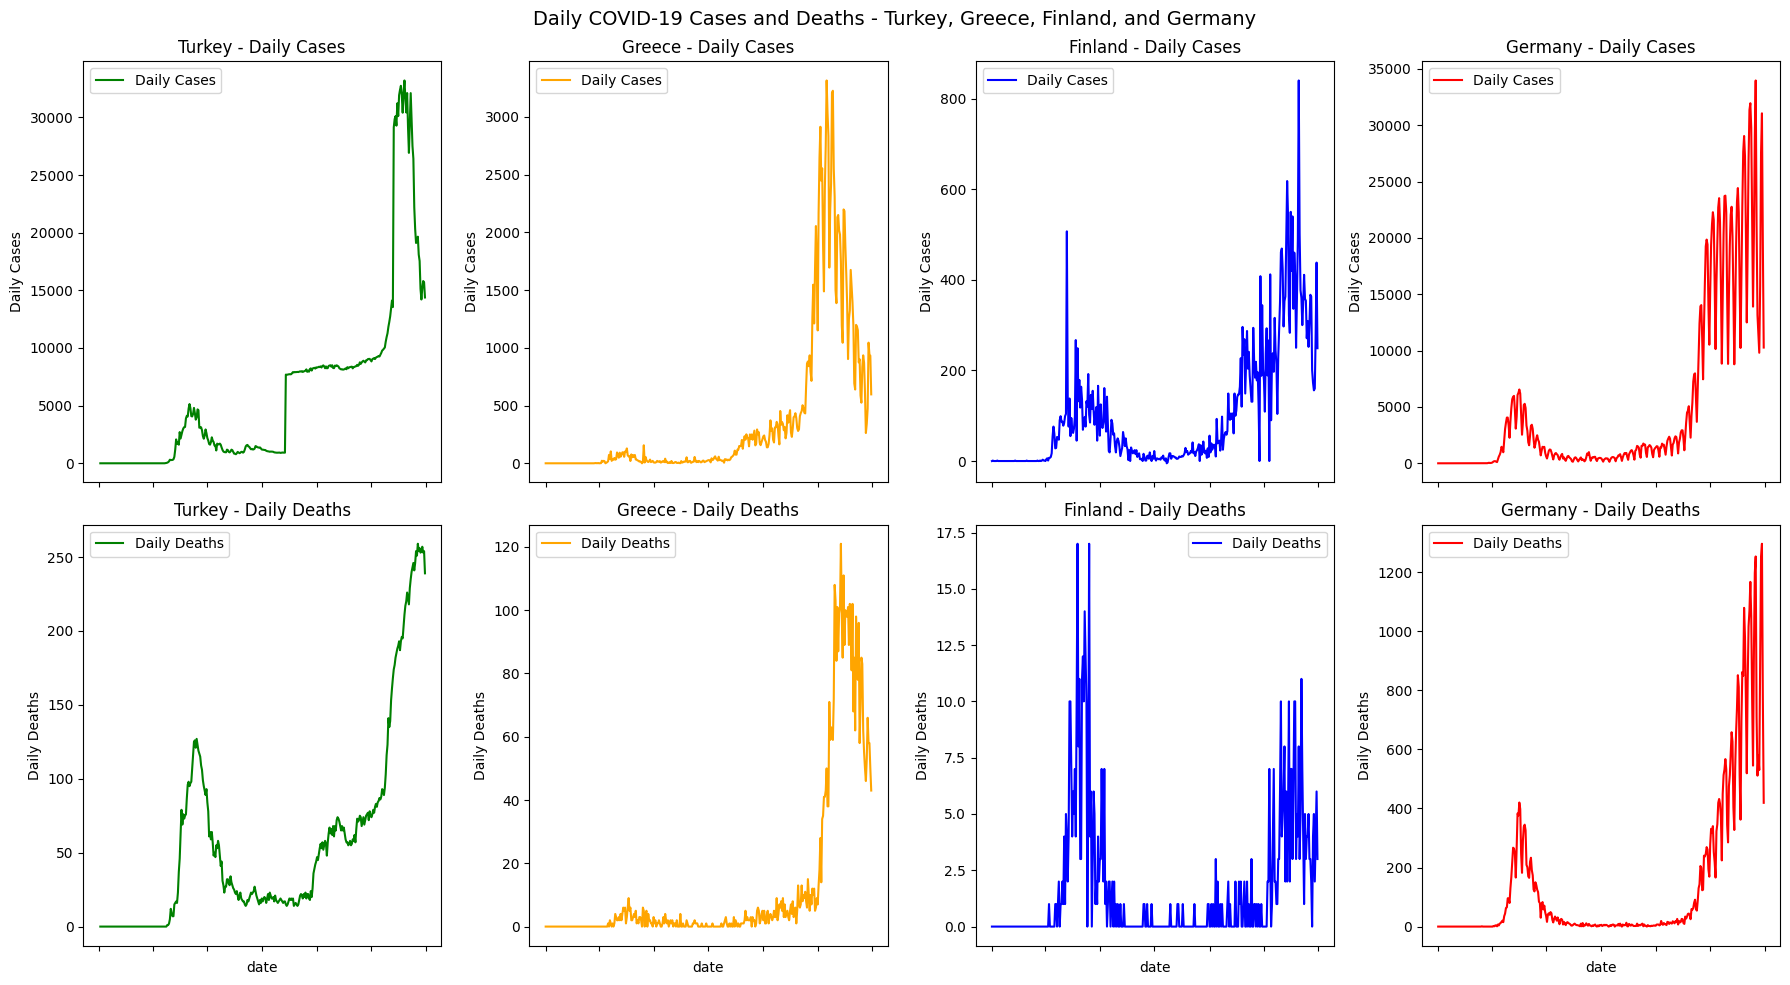

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the countries and colors
countries = ["Turkey", "Greece", "Finland", "Germany"]
titles = ["Daily Cases", "Daily Deaths"]
colors = ["green", "orange", "blue", "red"]

# Create subplots
fig, axes = plt.subplots(2, 4, figsize=(18, 10), sharex=True)

for col, country in enumerate(countries):
    # Filter data for the country
    country_data = df[df['country_name'] == country]

    # Plot Daily Cases (Row 1)
    sns.lineplot(ax=axes[0, col], data=country_data, x="date", y="daily_cases", color=colors[col], label="Daily Cases")
    axes[0, col].set_title(f"{country} - {titles[0]}")
    axes[0, col].set_ylabel("Daily Cases")
    axes[0, col].legend()

    # Hide x-axis labels for top row
    axes[0, col].set_xticklabels([])

    # Plot Daily Deaths (Row 2)
    sns.lineplot(ax=axes[1, col], data=country_data, x="date", y="daily_deaths", color=colors[col], label="Daily Deaths")
    axes[1, col].set_title(f"{country} - {titles[1]}")
    axes[1, col].set_ylabel("Daily Deaths")
    axes[1, col].legend()

# Set overall title
plt.suptitle("Daily COVID-19 Cases and Deaths - Turkey, Greece, Finland, and Germany", fontsize=14)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## **1. The Second Peak Appears in All Countries**  
- Across **Turkey, Greece, Finland, and Germany**, a **clear second peak** is observed **between October and December 2020**.  
- This aligns with the **global second wave** of COVID-19, which impacted many countries as colder weather increased indoor transmission.  
- The **steep rise in cases is accompanied by a rise in deaths**, particularly in **Turkey and Germany**, where fatalities sharply increased towards the end of the year.

## **2. The First Peak in Late July is Turkey-Specific**  
- **Turkey shows a distinct first peak in daily cases around July 2020**, which **does not appear in Greece, Finland, or Germany**.  
- Interestingly, this **spike appears to happen almost instantly, within a single day**, suggesting a sudden **data adjustment rather than a natural increase in cases**.  
- This strongly suggests that **Turkey may have revised its COVID-19 reporting system**, possibly switching from **only hospitalized cases** to **all positive cases**.
- In contrast, the other countries maintain **relatively stable case counts during July**, without any sudden increases.

## **3. Germany and Turkey Had the Highest Case Counts**  
- **Germany and Turkey report significantly higher daily case numbers** than Greece or Finland.  
- While Greece and Finland’s peaks remain in the **hundreds to low thousands**, Germany and Turkey surpass **30,000 daily cases at their peaks**.

## **4. Death Trends Follow Case Trends with a Delay**  
- In all countries, **daily deaths begin rising a few weeks after cases surge**, reflecting the **lag between infection and fatality**.  
- Turkey's **second wave of deaths is much steeper than its first**, consistent with the broader global trend.

---

## **Next Steps: Verifying the July Data Shift**  
- To **confirm whether the July peak in Turkey was due to a reporting change**, we can check the **BigQuery dataset** and analyze data between **2020-07-10 to 2020-08-30**.  
- If case numbers suddenly jump within **a single day**, it would strongly indicate a **reporting update rather than an actual surge in infections**.  
- A **comparison of daily testing numbers** before and after July could further validate whether an increase in testing contributed to this shift.


# **A Data Shift or a Real Surge? Understanding Turkey’s July 28 COVID-19 Spike**  

From **a steady ~900 daily cases** to **a shocking 7,693 overnight**, Turkey’s COVID-19 numbers didn’t just climb, they **skyrocketed**. Was this a true outbreak, or did the data finally catch up with reality?  

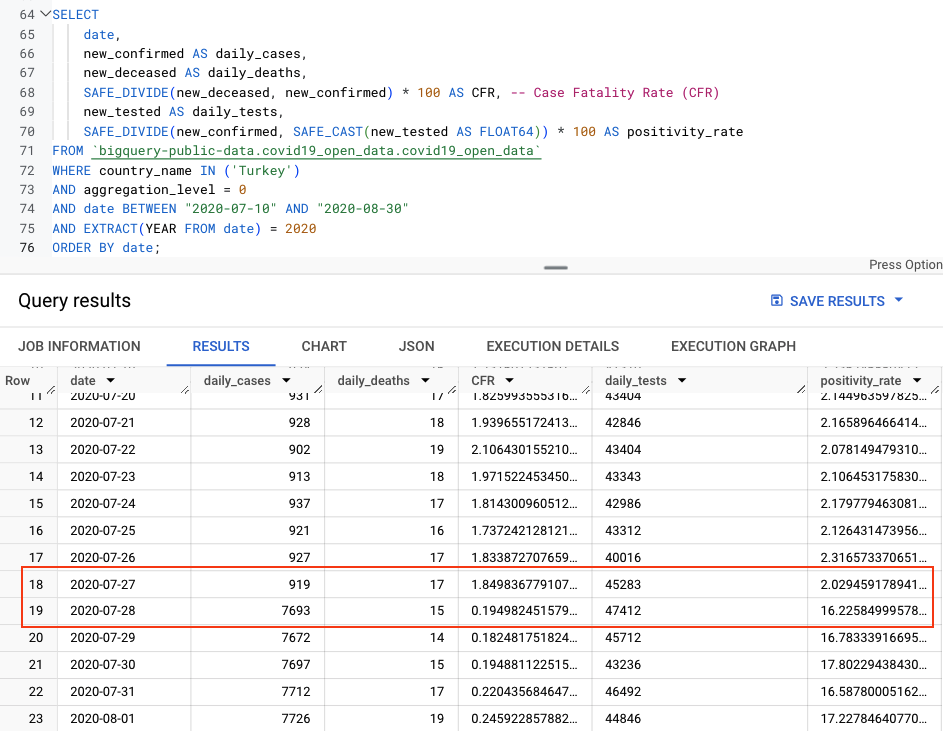

## **Observations from BigQuery Data**  
- Before **July 28, 2020**, Turkey’s daily reported cases were relatively stable, fluctuating between **900 and 940 cases per day**.  
- On **July 28, 2020**, a **massive spike occurs**, with **daily cases jumping from 937 on July 24 to 7,693 on July 28**, an **eightfold increase in a single day**.  
- The **positivity rate also rises dramatically** from **~2% to over 16%**, suggesting that **either significantly more testing was conducted or previously unreported cases were suddenly added**.  
- **However, the query output clearly shows that testing did not surge on July 28**, the number of daily tests **remained in the same range as previous days**.  
- **This pattern does not align with natural epidemiological trends**, where case numbers typically increase gradually rather than in an abrupt, singular jump.  

---

## **What This Implies**  
- The data strongly suggests that **Turkey changed its reporting methodology on July 28, 2020**.  
- The spike is likely due to **a backlog of previously unreported cases being included at once**, rather than an actual overnight explosion of infections.  
- **Before this date, only hospitalized cases may have been counted**, while **after July 28, all confirmed positive cases were reported**.  
- This could explain why **Turkey’s CFR dropped sharply after this date**, as a larger denominator (total cases) was suddenly introduced.  

---

## **Next Steps for Further Validation**  
- **Compare testing trends with case numbers more closely** to see if there was a **proportional increase** in tests or if **positivity rate surged independently**.  
- **Analyze Greece, Finland, and Germany** for July 28 to confirm whether this **pattern was unique to Turkey** or part of a broader trend.  

# **July 28 Spike: A Turkey-Only Phenomenon**  

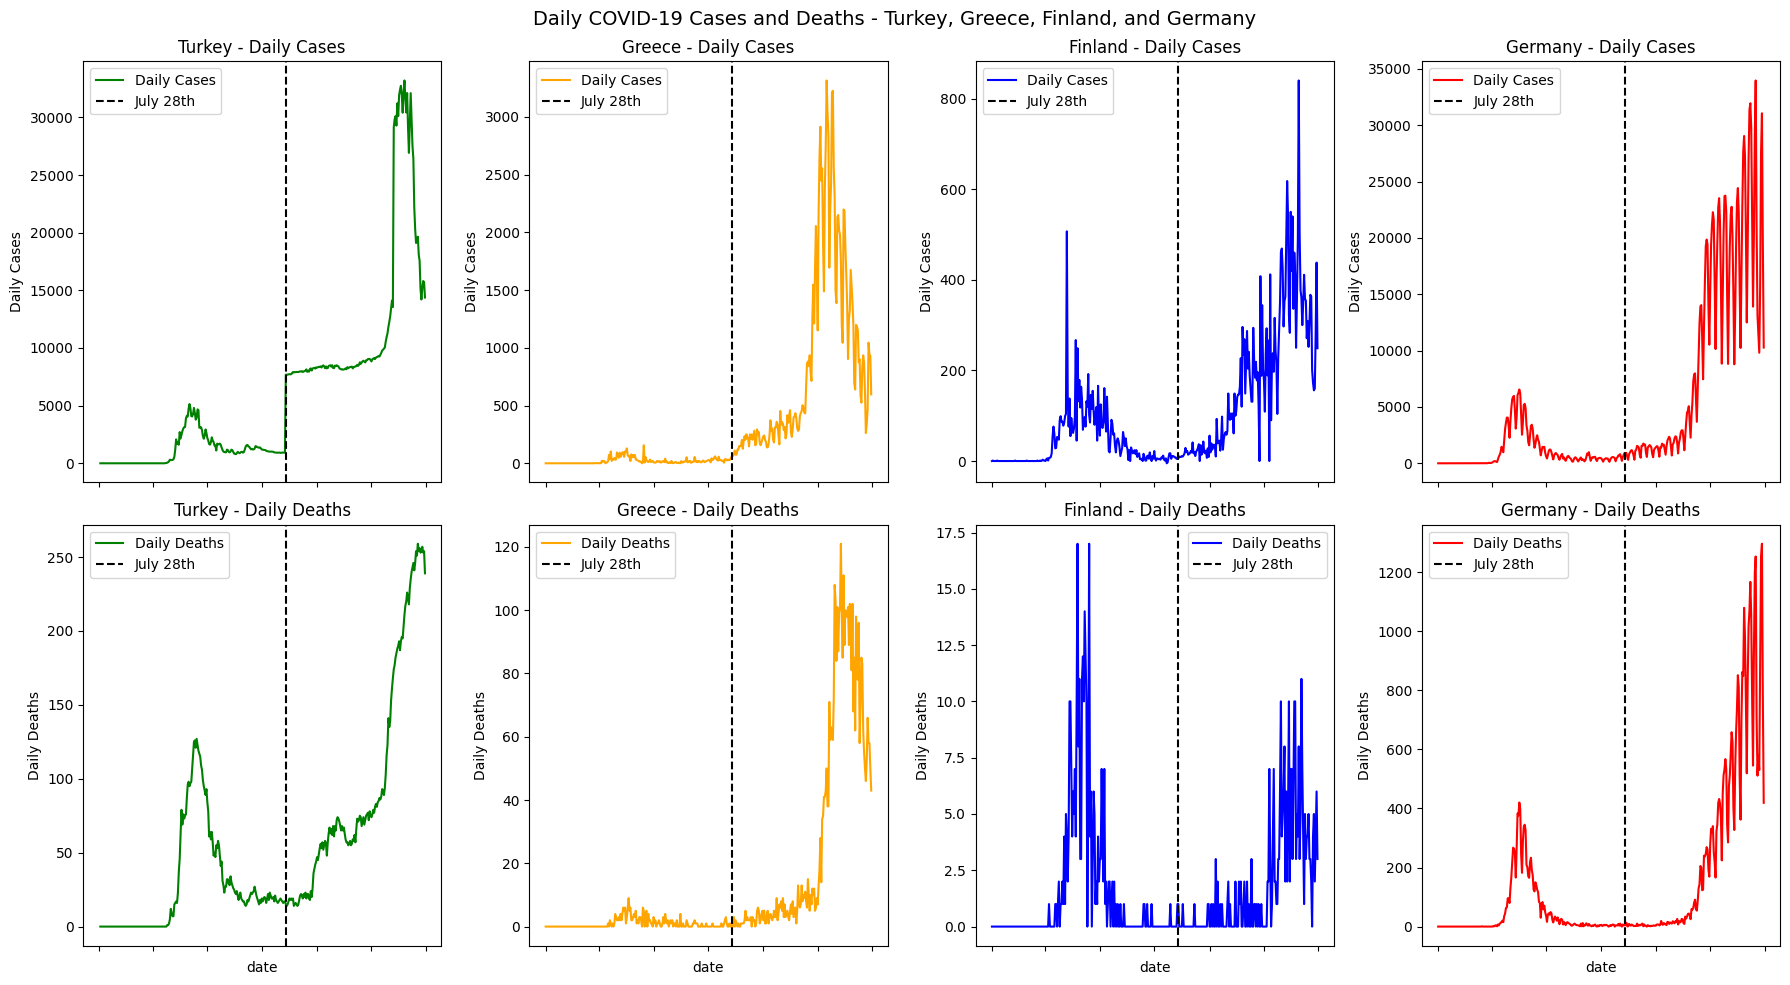

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

countries = ["Turkey", "Greece", "Finland", "Germany"]
titles = ["Daily Cases", "Daily Deaths"]
colors = ["green", "orange", "blue", "red"]

fig, axes = plt.subplots(2, 4, figsize=(18, 10), sharex=True)

for col, country in enumerate(countries):
    country_data = df[df['country_name'] == country]

    # Plot Daily Cases (Row 1)
    sns.lineplot(ax=axes[0, col], data=country_data, x="date", y="daily_cases", color=colors[col], label="Daily Cases")
    axes[0, col].axvline(pd.to_datetime("2020-07-28"), color='black', linestyle='--', label="July 28th")
    axes[0, col].set_title(f"{country} - {titles[0]}")
    axes[0, col].set_ylabel("Daily Cases")
    axes[0, col].legend()

    axes[0, col].set_xticklabels([])

    # Plot Daily Deaths (Row 2)
    sns.lineplot(ax=axes[1, col], data=country_data, x="date", y="daily_deaths", color=colors[col], label="Daily Deaths")
    axes[1, col].axvline(pd.to_datetime("2020-07-28"), color='black', linestyle='--', label="July 28th")
    axes[1, col].set_title(f"{country} - {titles[1]}")
    axes[1, col].set_ylabel("Daily Deaths")
    axes[1, col].legend()

plt.suptitle("Daily COVID-19 Cases and Deaths - Turkey, Greece, Finland, and Germany", fontsize=14)

plt.tight_layout()

plt.show()


Looking at the data from **Turkey, Greece, Finland, and Germany**, it's clear that the **massive jump in daily cases on July 28, 2020, is unique to Turkey**.  

- **Greece, Finland, and Germany** show **no sudden spike** around this date, maintaining their existing trends.  
- **Turkey's cases surge from ~900 to 7,693 overnight**, a pattern that does not align with natural epidemic progression.  
- This further supports the hypothesis that **Turkey changed its reporting methodology on this date**, likely shifting from **hospitalized cases only** to **all confirmed cases**.  

No other country in the dataset exhibits this **instantaneous jump**, making **July 28, 2020, a pivotal turning point in Turkey's COVID-19 data reporting**.  


# **Positivity Rate Spikes on July 28, But Testing Stays Flat, Why?**  


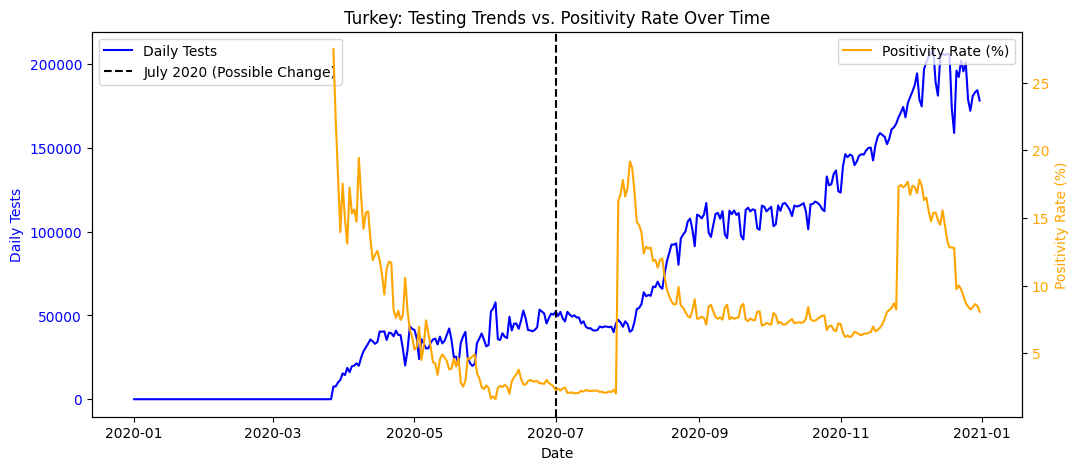

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 5))

sns.lineplot(data=df[df['country_name'] == "Turkey"], x="date", y="daily_tests", color="blue", label="Daily Tests", ax=ax1)
ax1.set_ylabel("Daily Tests", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

ax2 = ax1.twinx()
sns.lineplot(data=df[df['country_name'] == "Turkey"], x="date", y="positivity_rate", color="orange", label="Positivity Rate (%)", ax=ax2)
ax2.set_ylabel("Positivity Rate (%)", color="orange")
ax2.tick_params(axis='y', labelcolor="orange")

ax1.axvline(pd.to_datetime("2020-07-01"), color='black', linestyle='--', label="July 2020 (Possible Change)")

ax1.set_xlabel("Date")
plt.title("Turkey: Testing Trends vs. Positivity Rate Over Time")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()


### **Key Observations**  
- **On July 28, 2020, Turkey’s positivity rate (orange line) surges dramatically**, while **daily testing (blue line) remains stable**.  
- Normally, a rise in cases should be accompanied by a rise in testing, but here, **positivity skyrockets without a corresponding jump in tests**.  
- This strongly suggests that **previously unreported cases were suddenly included in the dataset**, rather than a natural increase in infections.  
- **After July 28, the positivity rate drops**, aligning with an adjustment rather than an outbreak.  

### **What This Confirms**  
- **Testing capacity did not significantly increase on July 28**, meaning the spike in cases was not due to more testing.  
- **The surge in positivity rate suggests that cases were already there but not reported earlier**.  
- This further reinforces the theory that **Turkey changed its case reporting methodology on this date**.  


# **From Numbers to Truth: A Roadmap to Understanding Turkey’s Case Surge**  



## **Step 1: The Mystery Begins – A Sudden Data Spike**  
Our investigation started with a **shocking anomaly**:  
📍 On **July 28, 2020**, Turkey’s **daily reported cases surged from ~900 to 7,693 overnight**—an almost **eightfold increase**.  
📍 The **positivity rate jumped from ~2% to over 16%**, yet **testing numbers remained stable**.  
📍 Such an **instantaneous rise** does not follow natural epidemiological trends.  

**Was this a true outbreak or a change in reporting methodology?**  

---

## **Step 2: Expanding the Investigation – Comparing with Other Countries**  
To determine if this was a **Turkey-specific event**, we examined data from:  
🇬🇷 **Greece** – A neighboring country with similar geographical and cultural factors.  
🇩🇪 **Germany** – A country known for transparent and consistent data reporting.  
🇫🇮 **Finland** – A control case with a different climate and policy approach.  

🔍 **The result?** None of these countries experienced a similar **July 28 surge**.  
🔍 **This confirmed that Turkey’s case spike was an isolated event**.  

---

## **Step 3: Digging Deeper – Analyzing CFR and Testing Trends**  
🛠 **Before July 2020:**  
✔ **Case Fatality Rate (CFR) was unusually high (2% - 5%)**, suggesting only **hospitalized cases were reported**.  

🛠 **After July 28, 2020:**  
✔ **CFR dropped dramatically (~0%)**, supporting the theory that Turkey **began reporting all positive cases, not just severe ones**.  

🛠 **What about testing?**  
✔ Testing **remained constant**—so the sudden spike was **not** due to increased testing.  
✔ This **strongly indicated a shift in case reporting methodology rather than a real-time surge in infections**.  

---

## **Step 4: The Breakthrough – Official Confirmation & Data-Driven Proof**  
Turkish health officials **acknowledged that, starting in late July, only hospitalized cases had been previously reported**, confirming our data-based hypothesis.  

However, even without this admission, **the numbers told the story**:  
📊 **A massive one-day case surge**  
📊 **Stable testing levels**  
📊 **A sharp drop in CFR**  
📊 **A pattern unique to Turkey, not observed in other countries**  

These clues pointed directly to a **case reporting change rather than an actual explosion of infections**.  

---

# **Conclusion: Data Unmasks the Truth**  
Even without an official statement, **the data itself revealed the shift in Turkey’s COVID-19 reporting system**. The July 28 surge wasn’t an epidemiological mystery, it was a **statistical transformation**.  

💡 **Key Takeaway:**  
Numbers don’t lie. **Analyzing data critically can uncover trends, anomalies, and even hidden policy changes, sometimes before governments admit them.**  


# **No Announcement, No Problem. Can We Detect a Data Shift?**, Answering the questions on github



### **Could This Shift Have Been Predicted Without Authorities Confirming It?**  
Yes. Even if Turkish officials had never publicly acknowledged the reporting change, the data alone provides strong indications that **something unusual happened on July 28, 2020**.  
- **Daily cases abruptly surged from ~900 to 7,693 in a single day**, an **unnatural and statistically improbable** increase if caused by actual virus spread.  
- **Testing numbers remained stable**, meaning the increase **was not due to expanded testing**, but rather a shift in how cases were counted.  
- **Positivity rate spiked dramatically**, indicating that cases were being reported differently rather than an actual explosion of infections.  

---

### **Can Data Records Confirm a Reporting Change?**  
Absolutely. The **combination of a sudden case surge, stable testing, and a sharp drop in CFR** strongly suggests that:  
1. **Before July 28, Turkey likely reported only hospitalized cases**, artificially keeping total case numbers low.  
2. **After July 28, all confirmed cases (including mild and asymptomatic) were included**, explaining the sudden surge.  
3. **A comparison with Greece, Finland, and Germany confirms this was Turkey-specific**, as no similar spikes occurred in those countries.  

---

### **How Can We Explain This Using Data?**  
- **Case trends before and after July 28 should be compared to identify a clear structural break.**  
- **Testing-to-case ratios should be examined** to determine if positivity rate shifts were due to underreporting before the change.  
- **A cross-country comparison provides external validation**, proving this anomaly was unique to Turkey and not part of a global trend.  

